<a href="https://colab.research.google.com/github/hsevras/Stamatics-deepflow/blob/main/assignment1/stamatics_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns: ['name', 'online_order', 'book_table', 'rating', 'votes', 'location', 'rest_type', 'cuisines', 'approx_costfor_two_people', 'listed_intype', 'listed_incity']
                    name online_order book_table  rating  votes      location  \
0                  Jalsa          Yes        Yes     4.1    775  Banashankari   
1         Spice Elephant          Yes         No     4.1    787  Banashankari   
2        San Churro Cafe          Yes         No     3.8    918  Banashankari   
3  Addhuri Udupi Bhojana           No         No     3.7     88  Banashankari   
4          Grand Village           No         No     3.8    166  Basavanagudi   

             rest_type                        cuisines  \
0        Casual Dining  North Indian, Mughlai, Chinese   
1        Casual Dining     Chinese, North Indian, Thai   
2  Cafe, Casual Dining          Cafe, Mexican, Italian   
3          Quick Bites      South Indian, North Indian   
4        Casual Dining        North Indian, Rajasthani  

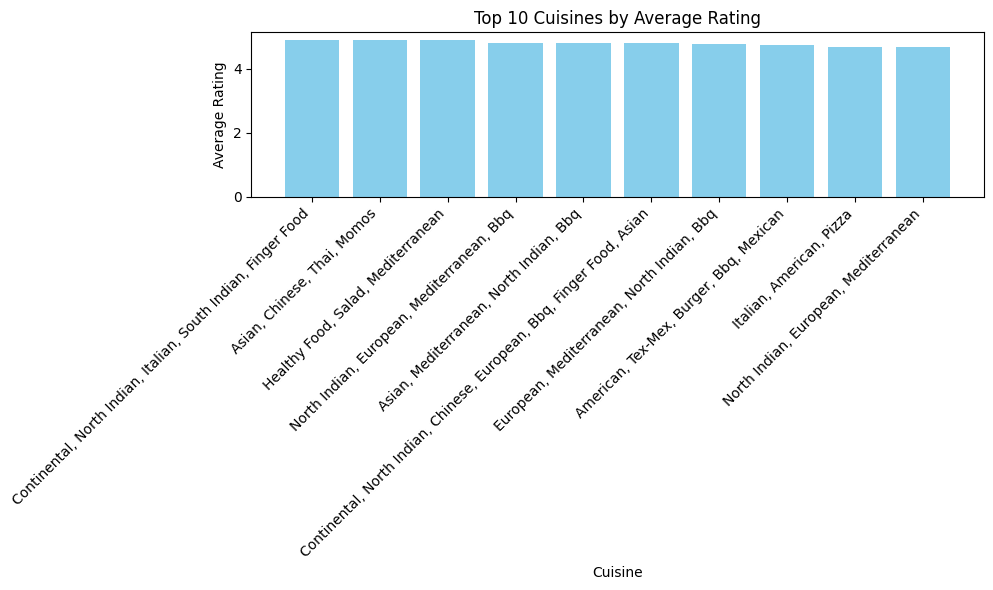

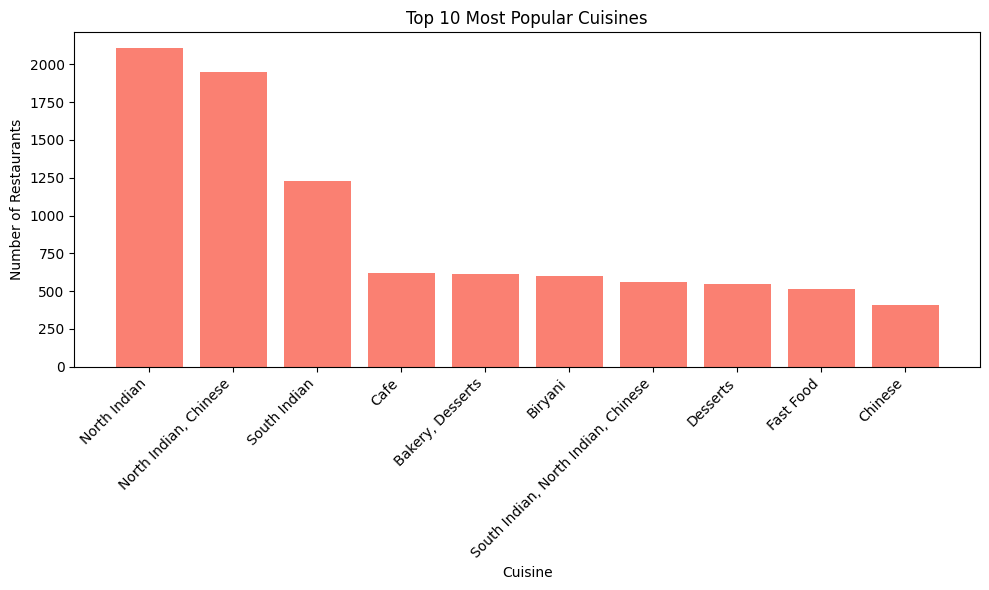

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
zomato_data = pd.read_excel('data.xlsx')

# Standardize column names for consistency
zomato_data.columns = (
    zomato_data.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('-', '_')
    .str.replace('[^a-z0-9_]', '', regex=True)
)

# Preview the data
print("Columns:", zomato_data.columns.tolist())
print(zomato_data.head())
print("Shape:", zomato_data.shape)
zomato_data.info()
print(zomato_data.describe())
print("Missing values:\n", zomato_data.isnull().sum())

# Handle missing values
if 'cuisines' in zomato_data.columns:
    zomato_data['cuisines'] = zomato_data['cuisines'].fillna('Unknown')
for feature in ['rating', 'votes', 'approx_costfor_two_people']:
    if feature in zomato_data.columns:
        zomato_data[feature] = zomato_data[feature].fillna(zomato_data[feature].median())

# Remove duplicate records
zomato_data = zomato_data.drop_duplicates()

# Clean up text columns
if 'cuisines' in zomato_data.columns:
    zomato_data['cuisines'] = zomato_data['cuisines'].astype(str).str.strip().str.title()
if 'currency' in zomato_data.columns:
    zomato_data['currency'] = zomato_data['currency'].astype(str).str.strip().str.upper()
if 'location' in zomato_data.columns:
    zomato_data['location'] = zomato_data['location'].astype(str).str.strip().str.title()

# Convert columns to correct data types
if 'rating' in zomato_data.columns:
    zomato_data['rating'] = pd.to_numeric(zomato_data['rating'], errors='coerce').clip(0, 5)
if 'approx_costfor_two_people' in zomato_data.columns:
    zomato_data['approx_costfor_two_people'] = pd.to_numeric(zomato_data['approx_costfor_two_people'], errors='coerce').astype('Int64')
if 'votes' in zomato_data.columns:
    zomato_data['votes'] = pd.to_numeric(zomato_data['votes'], errors='coerce').astype('Int64')
if 'date' in zomato_data.columns:
    zomato_data['date'] = pd.to_datetime(zomato_data['date'], errors='coerce')

# Save the cleaned dataset
zomato_data.to_excel('zomato_cleaned.xlsx', index=False)

# Group by cuisine and calculate averages
if 'cuisines' in zomato_data.columns:
    cuisine_stats = zomato_data.groupby('cuisines').agg({
        'rating': 'mean',
        'votes': 'mean',
        'approx_costfor_two_people': 'mean'
    }).reset_index().rename(columns={
        'rating': 'avg_rating',
        'votes': 'avg_votes',
        'approx_costfor_two_people': 'avg_price'
    })
    print("Cuisine group summary:\n", cuisine_stats.head())
else:
    cuisine_stats = pd.DataFrame()
    print("No 'cuisines' column found for grouping.")

# Top cuisines by rating and votes
if not cuisine_stats.empty:
    best_cuisines = cuisine_stats.sort_values(['avg_rating', 'avg_votes'], ascending=[False, False]).head(10)
    print("Top cuisines:\n", best_cuisines)
else:
    best_cuisines = pd.DataFrame()

# Best-rated restaurants for each cuisine
if 'cuisines' in zomato_data.columns and 'rating' in zomato_data.columns and 'restaurant_name' in zomato_data.columns:
    top_restaurants = zomato_data.loc[zomato_data.groupby('cuisines')['rating'].idxmax()][['restaurant_name', 'cuisines', 'rating']]
    print("Best-rated restaurants by cuisine:\n", top_restaurants.head())
else:
    top_restaurants = pd.DataFrame()

# User preferences by cuisine
if 'cuisines' in zomato_data.columns:
    cuisine_popularity = zomato_data['cuisines'].value_counts().reset_index()
    cuisine_popularity.columns = ['cuisines', 'count']
    print("User preferences by cuisine:\n", cuisine_popularity.head())
else:
    cuisine_popularity = pd.DataFrame()

# Visualizations
if not best_cuisines.empty:
    plt.figure(figsize=(10,6))
    plt.bar(best_cuisines['cuisines'], best_cuisines['avg_rating'], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Cuisines by Average Rating')
    plt.xlabel('Cuisine')
    plt.ylabel('Average Rating')
    plt.tight_layout()
    plt.show()

if not cuisine_popularity.empty:
    plt.figure(figsize=(10,6))
    plt.bar(cuisine_popularity['cuisines'][:10], cuisine_popularity['count'][:10], color='salmon')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Popular Cuisines')
    plt.xlabel('Cuisine')
    plt.ylabel('Number of Restaurants')
    plt.tight_layout()
    plt.show()
